In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import gym
import matplotlib.pyplot as plt
import torch

from agent import Agent, add_noise
from hill_climbing import perform_hill_climbing

https://openai.com/requests-for-research/#cartpole

## Explore `gym` and the `CartPole-v0` environment

In [7]:
env = gym.envs.make('CartPole-v0')

/home/mkurovski/anaconda3/envs/drl/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [8]:
env.reset()

array([-0.01780566, -0.02894957,  0.01962443, -0.03215383])

In [9]:
env.action_space

Discrete(2)

In [10]:
env.observation_space

Box(4,)

Watch an untrained agent

In [11]:
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
cartpole_agent.watch_me(env, steps=500)

## Apply Hill Climbing Algorithm to solve Environment

In [12]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 2000
initial_noise_std = 0.3

In [13]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  initial_noise_std=initial_noise_std,
                                                  population_size=1)

Start with Return Estimate G = 21.0
Episode 3 - Improved G to G_best = 38.0
Episode 24 - Improved G to G_best = 46.0
Episode 169 - Improved G to G_best = 59.0
Episode 181 - Improved G to G_best = 72.0
Episode 205 - Improved G to G_best = 77.0
Episode 269 - Improved G to G_best = 95.0
Episode 309 - Improved G to G_best = 104.0
Episode 383 - Improved G to G_best = 112.0
Episode 523 - Improved G to G_best = 178.0


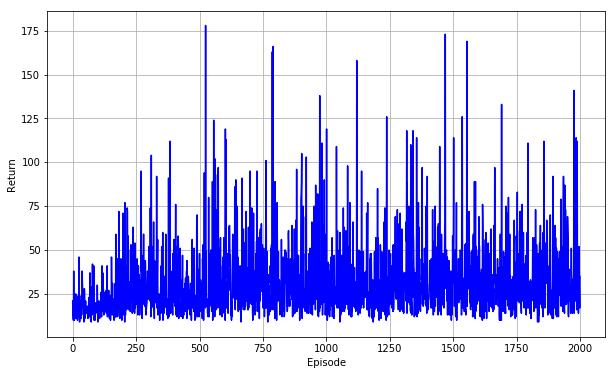

In [14]:
plt.figure(figsize=(10,6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

Watch a (slightly) improved agent

In [15]:
opt_agent.watch_me(env, steps=500)

## Change over to Steepest Ascent Hill Climbing and its Flavors

### without adaptive noise

In [16]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 500
initial_noise_std = 0.3
population_size = 10
use_adaptive_noise = False

In [17]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise)

Start with Return Estimate G = 21.0
Episode 0 - Improved G to G_best = 42.0
Episode 1 - Improved G to G_best = 43.0
Episode 11 - Improved G to G_best = 50.0
Episode 13 - Improved G to G_best = 51.0
Episode 15 - Improved G to G_best = 78.0
Episode 16 - Improved G to G_best = 84.0
Episode 18 - Improved G to G_best = 111.0
Episode 57 - Improved G to G_best = 122.0
Episode 68 - Improved G to G_best = 126.0
Episode 72 - Improved G to G_best = 158.0
Episode 73 - Improved G to G_best = 185.0
Episode 103 - Improved G to G_best = 195.0
Episode 111 - Improved G to G_best = 197.0
Episode 120 - Improved G to G_best = 200.0


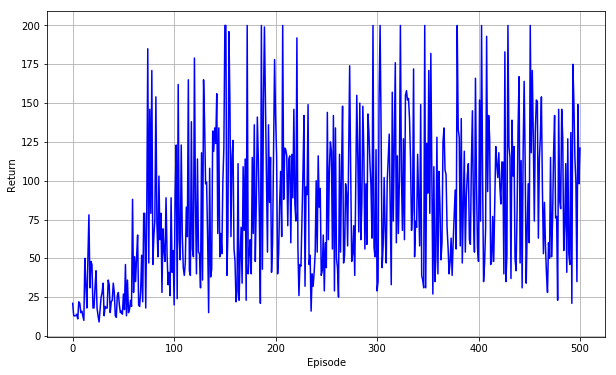

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [20]:
opt_agent.watch_me(env, steps=500)

### with adaptive noise

In [21]:
torch.random.manual_seed(42)
cartpole_agent = Agent(state_size=env.observation_space.shape[0],
                       action_size=env.action_space.n,
                       hidden_size_1=16)
n_episodes = 500
initial_noise_std = 0.3
population_size = 10
use_adaptive_noise = True

In [22]:
opt_agent, return_history = perform_hill_climbing(cartpole_agent, env, n_episodes=n_episodes,
                                                  population_size=population_size,
                                                  initial_noise_std=initial_noise_std,
                                                  use_adaptive_noise=use_adaptive_noise)

Start with Return Estimate G = 14.0
Episode 0 - Improved G to G_best = 45.0
Episode 1 - Improved G to G_best = 83.0
Episode 11 - Improved G to G_best = 106.0
Episode 33 - Improved G to G_best = 123.0
Episode 41 - Improved G to G_best = 134.0
Episode 43 - Improved G to G_best = 154.0
Episode 62 - Improved G to G_best = 172.0
Episode 69 - Improved G to G_best = 200.0


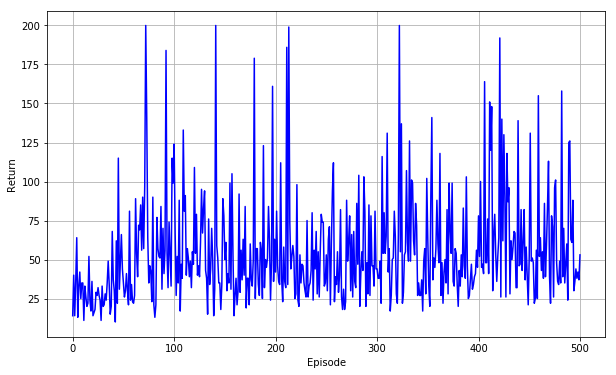

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(range(len(return_history)), return_history, 'b-')
plt.grid(True)
plt.xlabel('Episode')
plt.ylabel('Return')
plt.show()

In [24]:
opt_agent.watch_me(env, steps=500)